In [1]:
'''
Here we will just be implementing the code part that will go inside main
before that let me write the steps that we are going to implement

What are the things that we need to implement the onlineKnapsack Problem?
Let's define the MDP :
1. State space 
   ( timeRemaining, usedCapacity, itemIndex ) -> ( 50 * 200 * 200 )
   timeRemaining -> ( 0 to episodeLength )
   usedCapacity -> current knapSack capacity
   itemIndex -> the index of the item selected
2. Action :
   accept : if item fits
   reject
3. Transition :
   Next state if itemIndexI is offered = {
      if agent rejects moves to -> (timeRemaining−1, usedCapacity, itemIndex)
      else if accepts : moves to -> (timeRemaining - 1, usedCapacity + weight[i], itemIndexI)
4. Reward:

    If accept → reward = value[j]
    If reject → reward = 0

Next, 
Let maxm capacity allowed = W

Value function :
      ValFn(t,C,i)=optimal reward achievable with t steps left, used capacity C, and current item i.
    So,
      ValFn(0,C,i)=0 ∀C,i ( terminal state ) 

And policy :
π[t, C, i] → policy (0 = reject, 1 = accept

3. Bellman update

At (timeRemmaining, usedCapacity, itemIndex) with item (weight[i], value[i]):

Reject Qreject = Ej∼D​[ValFn(timeRemmaining−1,usedCapacity,j)]

Accept only if ( usedCapacity+weight[i] ≤ W ):
       Qaccept = value[i] + Ej∼D​[ValFn(timeRemmaining−1,usedCapacity+weight[i],j)]

Then,
       ValFn[timeRemmaining, usedCapacity, itemIndex ] = max( Qreject, Qaccept )
'''
print("Setting up the environment for knapsack solution!!")

Setting up the environment for knapsack solution!!


In [2]:
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from or_gym.envs.classic_or.knapsack import OnlineKnapsackEnv
from policyIterationOnlineKnapsack import PolicyIterationOnlineKnapsack
from valueIterationOnlineKnapsack import ValueIterationOnlineKnapsack

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [3]:
def compareVIAndPI(optimalPolicyPI, optimalValueFnPI, optimalPolicyVI, optimalValueFnVI):
    
    # Check how many elements differ
    num_differences = np.sum(optimalPolicyPI != optimalPolicyVI)
    print("Number of differing elements:", num_differences)

    print(np.allclose(optimalValueFnVI, optimalValueFnPI, atol=1e-3))
    print("VI value function mean:", np.mean(optimalValueFnVI))
    print("PI value function mean:", np.mean(optimalValueFnPI))
    print("Max abs difference:", np.max(np.abs(optimalValueFnPI - optimalValueFnVI)))

In [4]:
def evaluate_policy(model, policy):
    startState = model.env._RESET()
    done = False
    total_reward = 0
    timeRemaining = model.episodeLength
    curr_s = startState
    values_over_time = []
    
    print(f"Start state for Online Knapsack for PI Case: {startState}")

    while not done and timeRemaining > 0:
#         stateTuple = (timeRemaining, curr_s['state'][0], curr_s['state'][1])
        # timeRemaining, usedCapacity, itemIdx
        action = policy[timeRemaining, curr_s['state'][0], curr_s['state'][1]]
        next_state, reward, done, info = model.env._STEP(action)
        
        total_reward += reward
        curr_s = next_state
        timeRemaining -= 1
        values_over_time.append(total_reward)
        
        # print(f"Action: {'Accept' if action == 1 else 'Reject'} | Reward: {reward} | Next state: {next_state} | Done: {done}")

    return total_reward, values_over_time

In [5]:
def plot_value_heatmap(V, env, sort_by, model, method, timeRemaining = 1,  episodeLength = 50):
    weights = env.item_weights
    values = env.item_values
    ratios = values / weights

    # choose sorting
    if sort_by == "weight":
        idx = np.argsort(weights)
        xlabels = weights[idx]
    elif sort_by == "value":
        idx = np.argsort(values)
        xlabels = values[idx]
    elif sort_by == "ratio":
        idx = np.argsort(ratios)
        xlabels = np.round(ratios[idx], 2)
    else:
        raise ValueError("sort_by must be 'weight', 'value', or 'ratio'")

    max_capacity = model.maxmKnapsackWeight

    # heatmap [capacity × item]
    heatmap = np.zeros((max_capacity+1, len(weights)))
    for cap in range(max_capacity + 1):
        for itemIdx, sortIdx in enumerate(idx):
            heatmap[cap, itemIdx] = V[timeRemaining, cap, sortIdx]

    plt.figure(figsize=(15, 6))
    sns.heatmap(heatmap, cmap="viridis", xticklabels=xlabels)
    plt.ylabel("Current knapsack weight")
    plt.xlabel(f"Items sorted by {sort_by}")
    plt.title(f"Heatmap of Value Function by {method} for timeRemaining {timeRemaining} and episodeLength : {episodeLength}")
    plt.show()

In [6]:
def plotTrajectories(trajectories, seeds):
    # plot the trajectories
    plt.figure(figsize=(10,6))

    for seed in seeds:
        plt.plot(trajectories[seed], label=f"Seed {seed}")

    plt.xlabel("Time step (items presented)")
    plt.ylabel("Cumulative knapsack value")
    plt.title("Value of knapsack during evaluation by Policy Iteration")
    plt.legend()
    plt.show()

In [7]:
seeds = [0, 10, 20, 30, 40]

In [ ]:
# Q1 :: For Policy iteration :: Given the seeds, we are trying to build the respective trajectories of the optimal policy found
final_valuesPI = {}
trajectoriesPI = {}

for seed in seeds:

    np.random.seed(seed)
    env = OnlineKnapsackEnv()
    
    policy_iteration = PolicyIterationOnlineKnapsack(env, episodeLength = 50)
    optimalPolicyPI, optimalValueFnPI = policy_iteration.run_policy_iteration()
    total_reward, values_over_time = evaluate_policy(policy_iteration, optimalPolicyPI)
    
    final_valuesPI[seed] = total_reward
    trajectoriesPI[seed] = values_over_time
    
    print(f"Seed {seed}: Reward = {total_reward}")
    
plotTrajectories(trajectoriesPI, seeds)

episode_length = policy_iteration.episodeLength

# finally we will be building heap map for the last seed 
plot_value_heatmap(optimalValueFnPI, env, "weight", policy_iteration, "PI", timeRemaining = episode_length, episodeLength = episode_length)
plot_value_heatmap(optimalValueFnPI, env, "value", policy_iteration,  "PI", timeRemaining = episode_length, episodeLength = episode_length)
plot_value_heatmap(optimalValueFnPI, env, "ratio", policy_iteration, "PI", timeRemaining = episode_length, episodeLength = episode_length)

Shape of item_values : (200,)
Shape of policy : (51, 201, 200)
Shape of valueFn : (51, 201, 200)
delta : 0
Errors in policy : 1520850
delta : 316.0525860870708
delta : 0
Errors in policy : 578079
delta : 193.59854233667207
delta : 0
Errors in policy : 167445
delta : 64.40085260002621
delta : 0
Errors in policy : 21912
delta : 10.761147096767075
delta : 0
Errors in policy : 1082
delta : 0.8130959754253411
delta : 0
Errors in policy : 9
delta : 0.0030048944187797133
delta : 0
Errors in policy : 0
The policy iteration took 7 iterations to converge
Start state for Online Knapsack for PI Case: {'state': array([ 0, 73, 66, 41]), 'avail_actions': array([1, 1], dtype=uint8), 'action_mask': array([1, 1], dtype=uint8)}
Seed 0: Reward = 562
Shape of item_values : (200,)
Shape of policy : (51, 201, 200)
Shape of valueFn : (51, 201, 200)
delta : 0
Errors in policy : 1509500
delta : 305.40879773431004
delta : 0
Errors in policy : 608745
delta : 187.50650890544242
delta : 0
Errors in policy : 167512


Shape of item_values : (200,)
Shape of policy : (51, 201, 200)
Shape of valueFn : (51, 201, 200)
delta : 411.75972631382314
delta : 0
Start state for Online Knapsack for PI Case: {'state': array([ 0, 73, 66, 41]), 'avail_actions': array([1, 1], dtype=uint8), 'action_mask': array([1, 1], dtype=uint8)}
Seed 0: Reward = 562
Shape of item_values : (200,)
Shape of policy : (51, 201, 200)
Shape of valueFn : (51, 201, 200)
delta : 397.5106300817216
delta : 0
Start state for Online Knapsack for PI Case: {'state': array([ 0, 82,  8, 95]), 'avail_actions': array([1, 1], dtype=uint8), 'action_mask': array([1, 1], dtype=uint8)}
Seed 10: Reward = 515
Shape of item_values : (200,)
Shape of policy : (51, 201, 200)
Shape of valueFn : (51, 201, 200)
delta : 423.3940464920308
delta : 0
Start state for Online Knapsack for PI Case: {'state': array([  0, 131,  18,  88]), 'avail_actions': array([1, 1], dtype=uint8), 'action_mask': array([1, 1], dtype=uint8)}
Seed 20: Reward = 699
Shape of item_values : (200

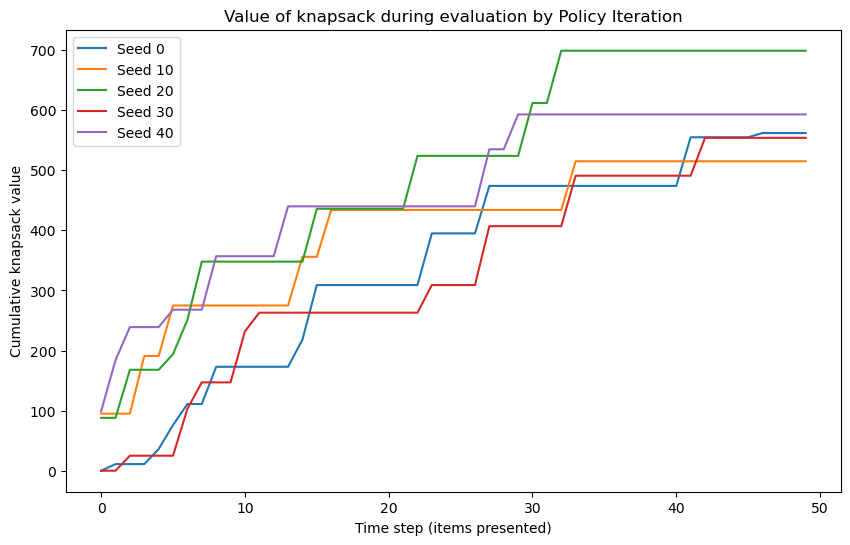

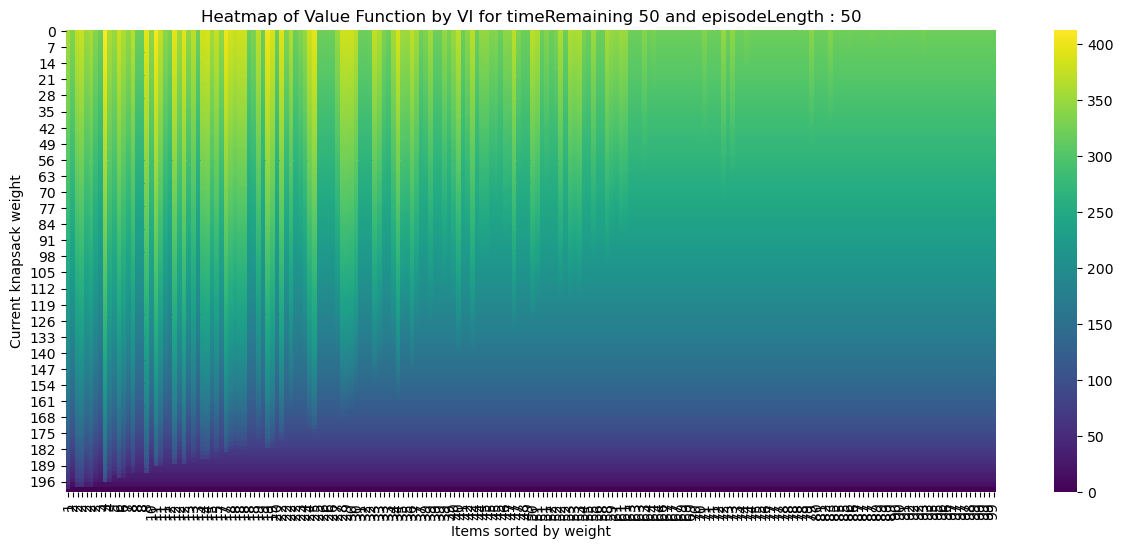

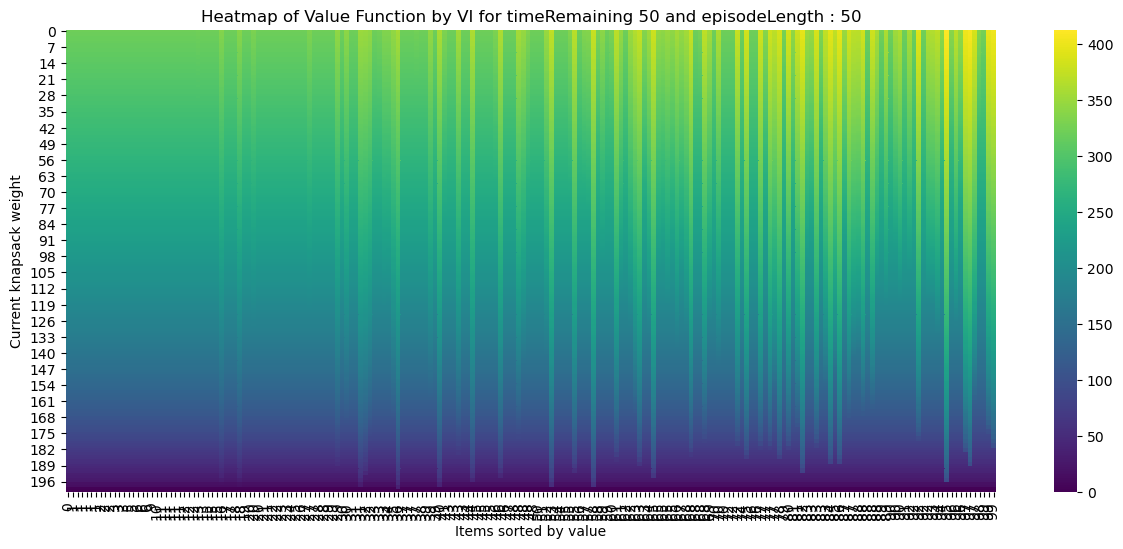

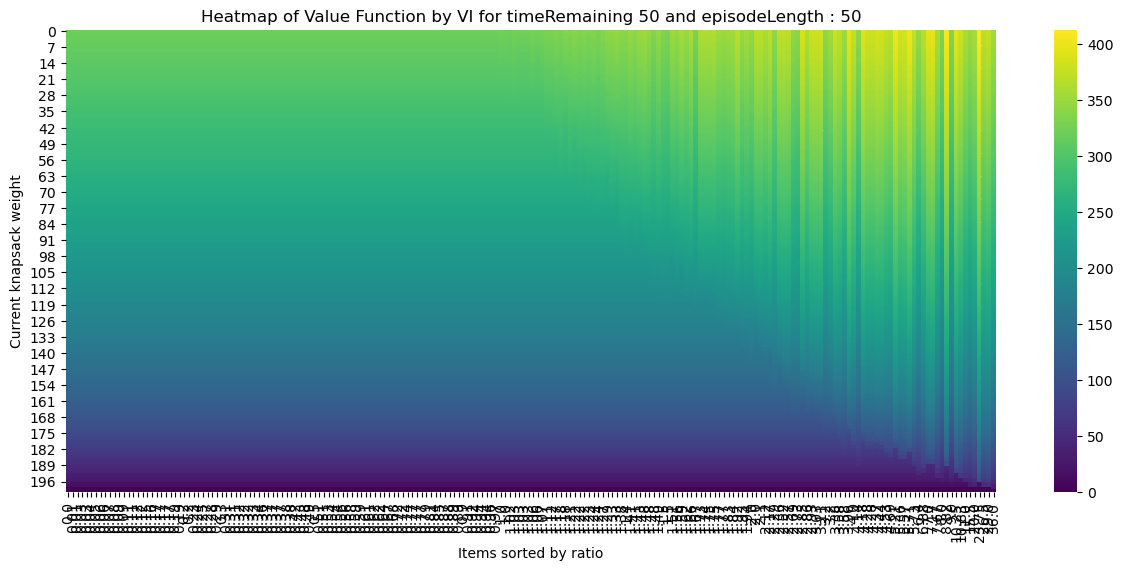

In [10]:
# Question 2
final_valuesVI = {}
trajectoriesVI = {}

for seed in seeds:
    np.random.seed(seed)
    env = OnlineKnapsackEnv()
    
    value_iteration = ValueIterationOnlineKnapsack(env, episodeLength = 50)
    optimalPolicyVI, optimalValueFnVI = value_iteration.run_value_iteration()
    total_reward, values_over_time  = evaluate_policy(value_iteration, optimalPolicyVI)
    
    final_valuesVI[seed] = total_reward
    trajectoriesVI[seed] = values_over_time
    
    print(f"Seed {seed}: Reward = {total_reward}")

plotTrajectories(trajectoriesVI, seeds)

# finally we will be building heap map for the last seed 
episode_length = value_iteration.episodeLength

plot_value_heatmap(optimalValueFnVI, env, "weight", value_iteration, "VI", timeRemaining = episode_length, episodeLength = episode_length)
plot_value_heatmap(optimalValueFnVI, env, "value", value_iteration, "VI", timeRemaining = episode_length, episodeLength = episode_length)
plot_value_heatmap(optimalValueFnVI, env, "ratio", value_iteration, "VI", timeRemaining = episode_length, episodeLength = episode_length)

Shape of item_values : (200,)
Shape of policy : (11, 201, 200)
Shape of valueFn : (11, 201, 200)
delta : 319.60565833540375
delta : 0
Episode Length : 10
(11, 201, 200)


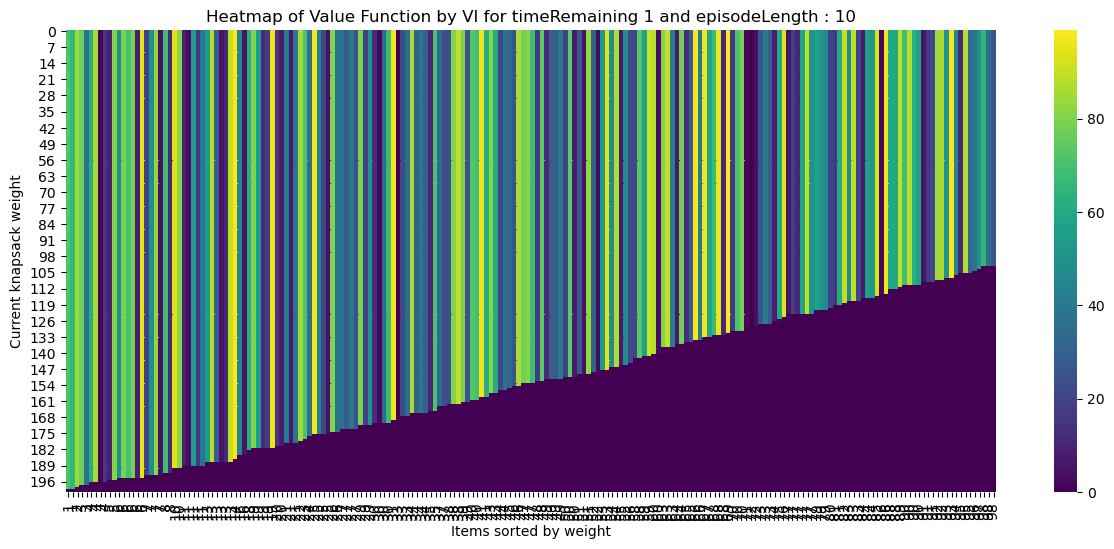

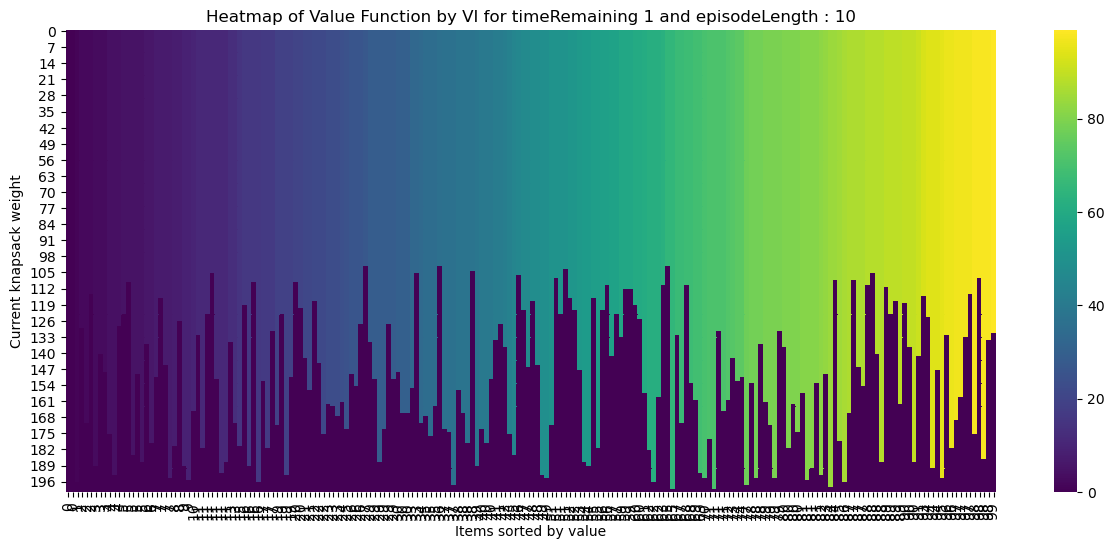

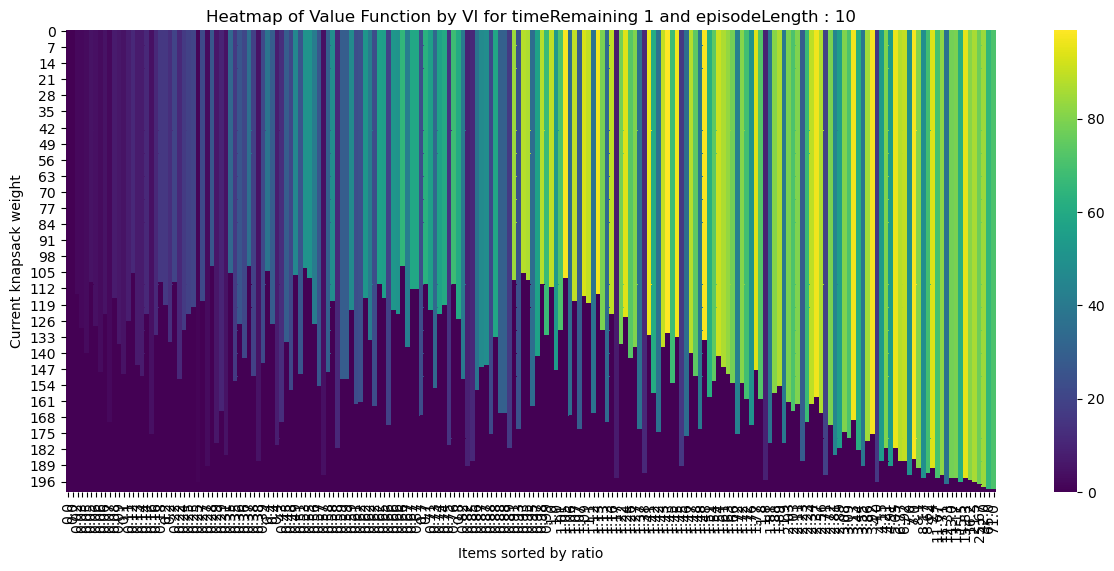

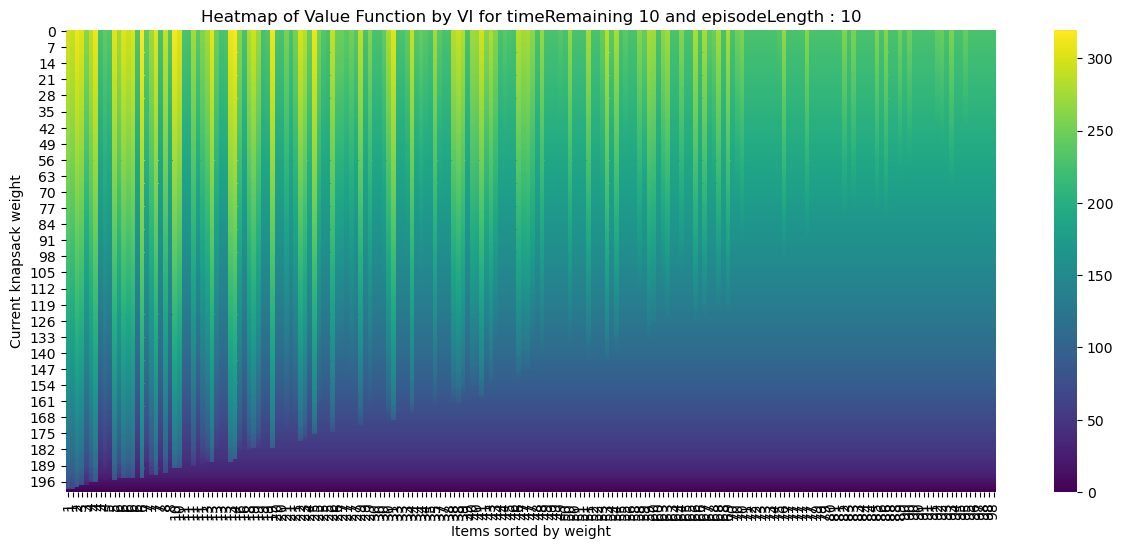

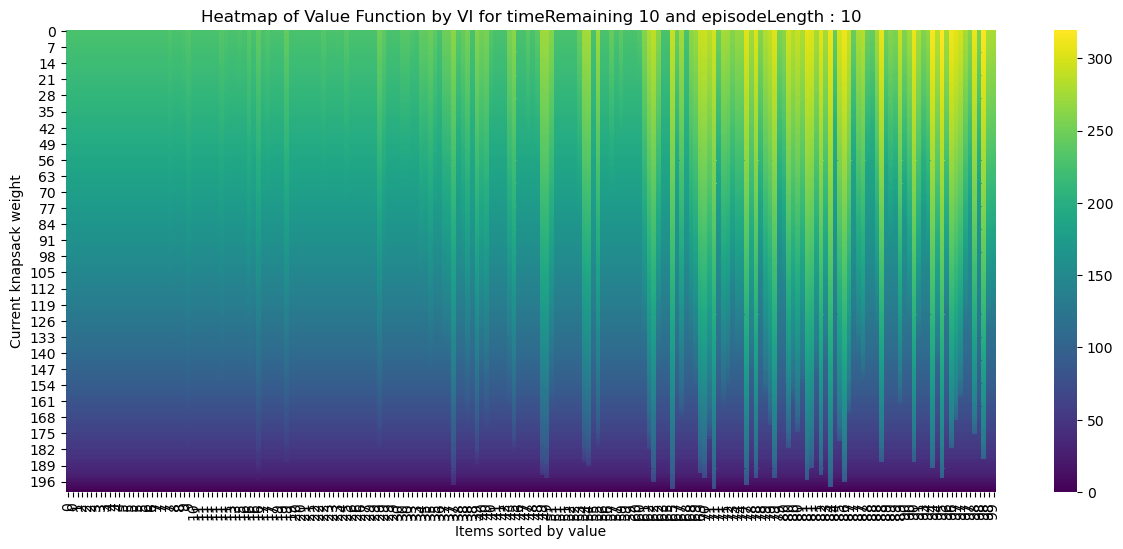

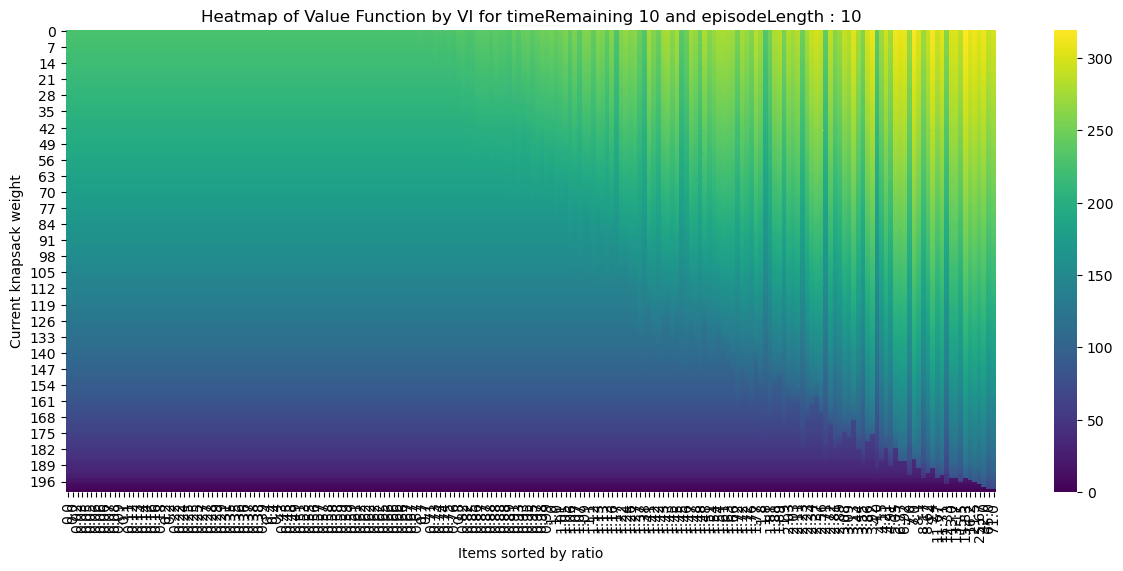

Shape of item_values : (200,)
Shape of policy : (51, 201, 200)
Shape of valueFn : (51, 201, 200)
delta : 411.75972631382314
delta : 0
Episode Length : 50
(51, 201, 200)


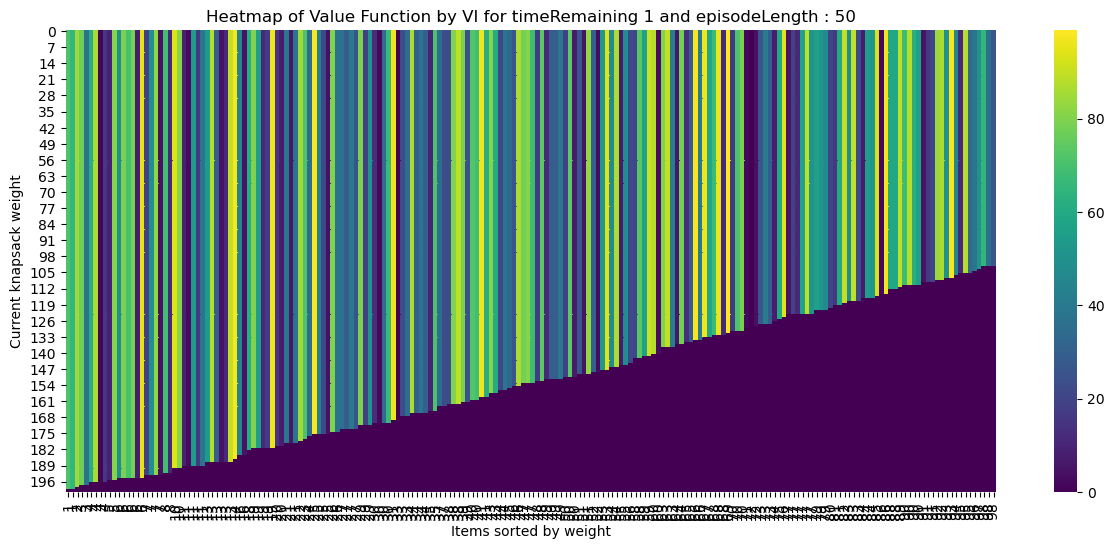

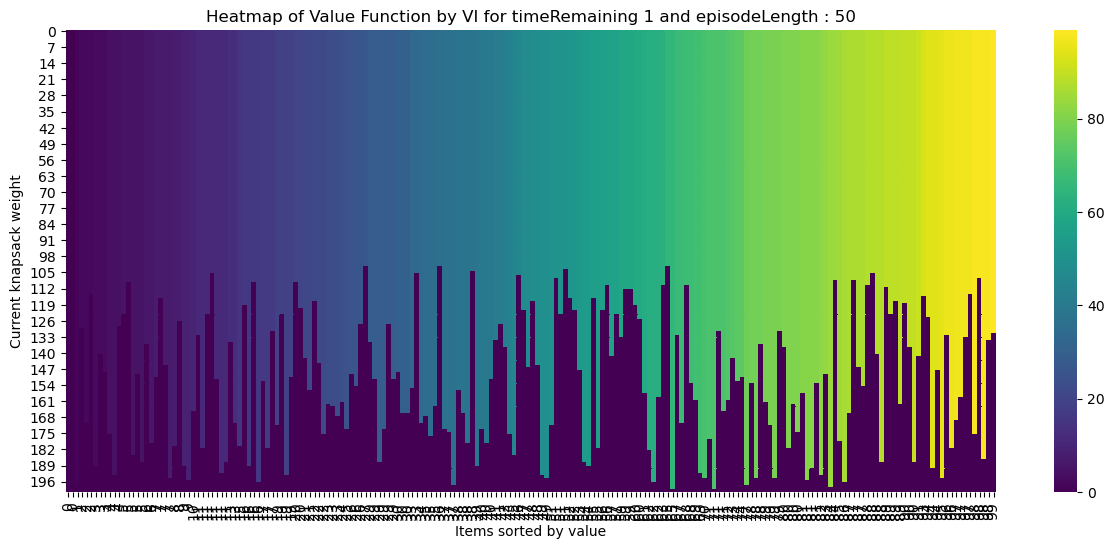

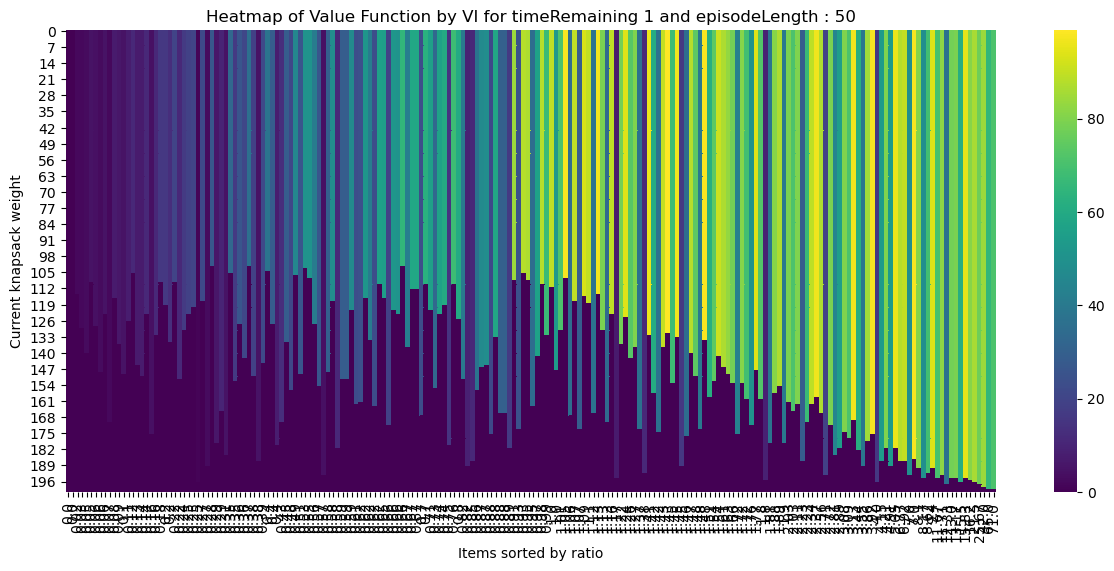

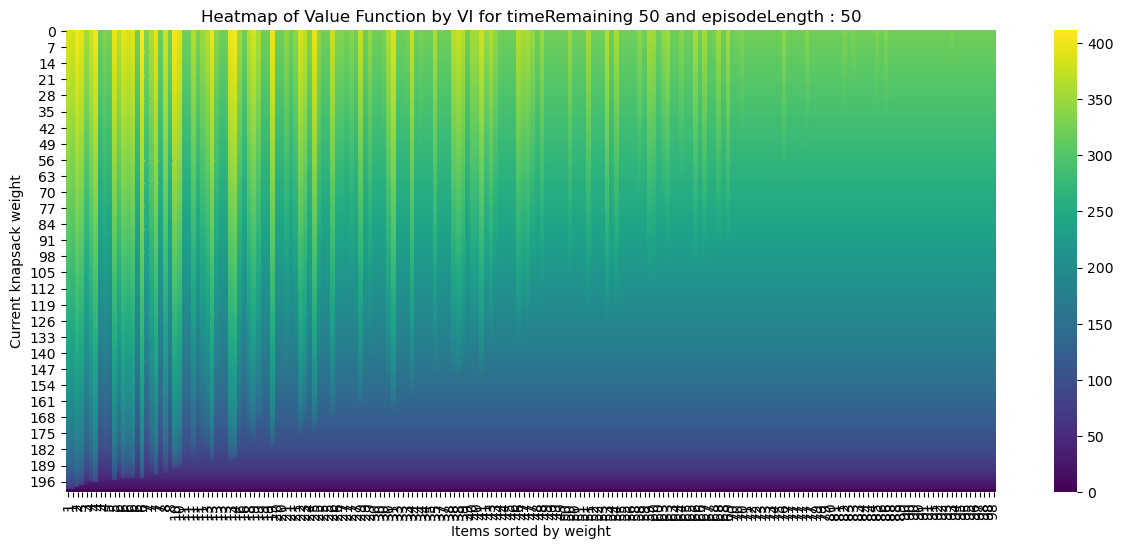

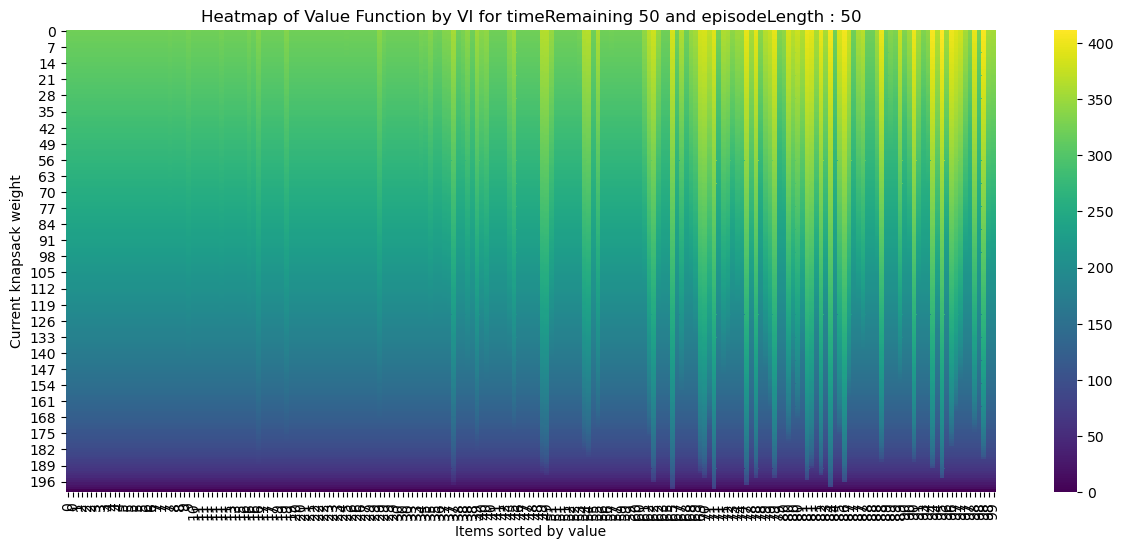

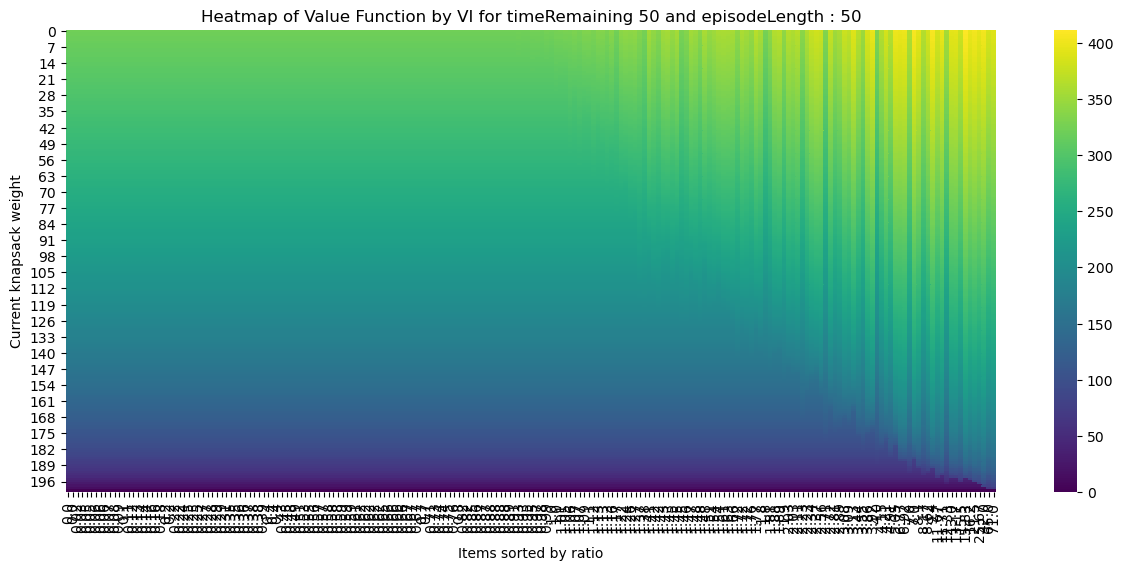

Shape of item_values : (200,)
Shape of policy : (501, 201, 200)
Shape of valueFn : (501, 201, 200)
delta : 415.763055181051
delta : 0
Episode Length : 500
(501, 201, 200)


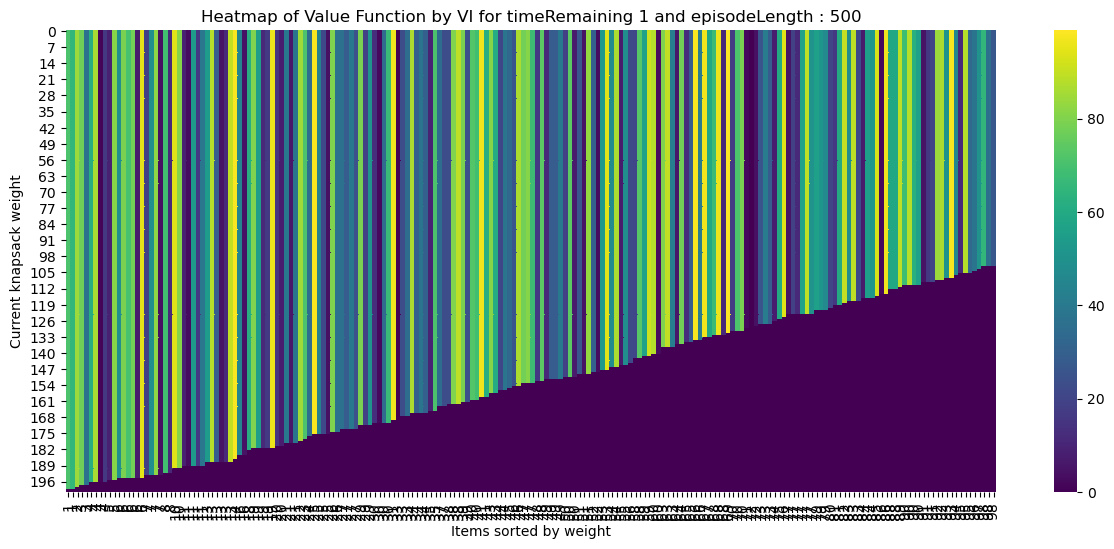

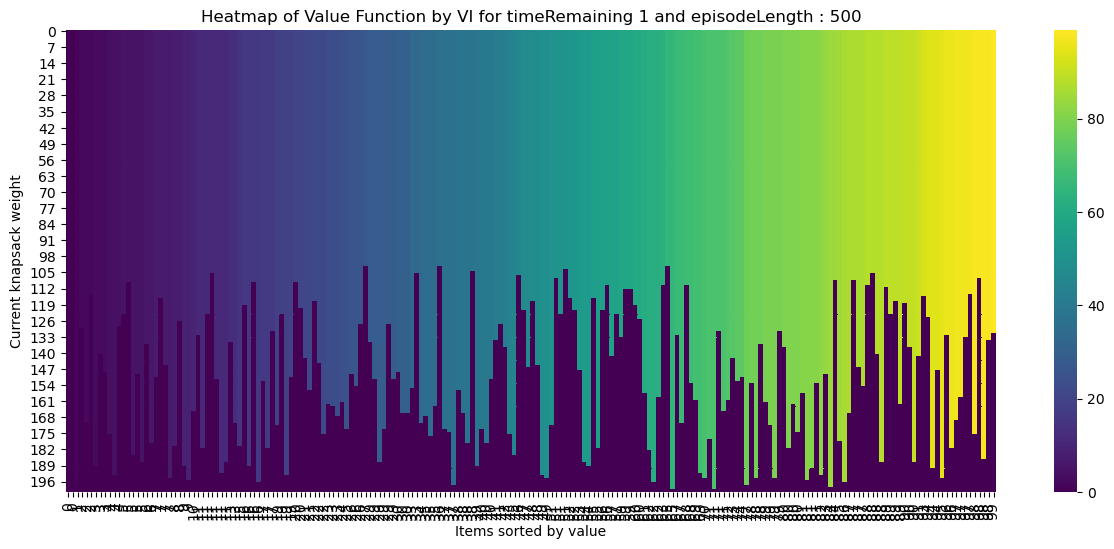

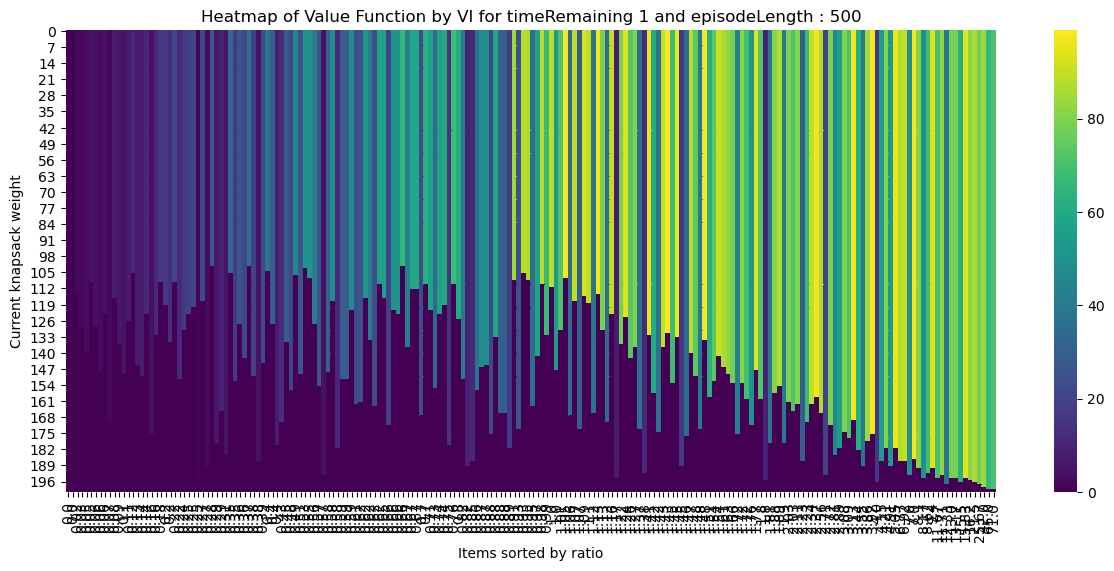

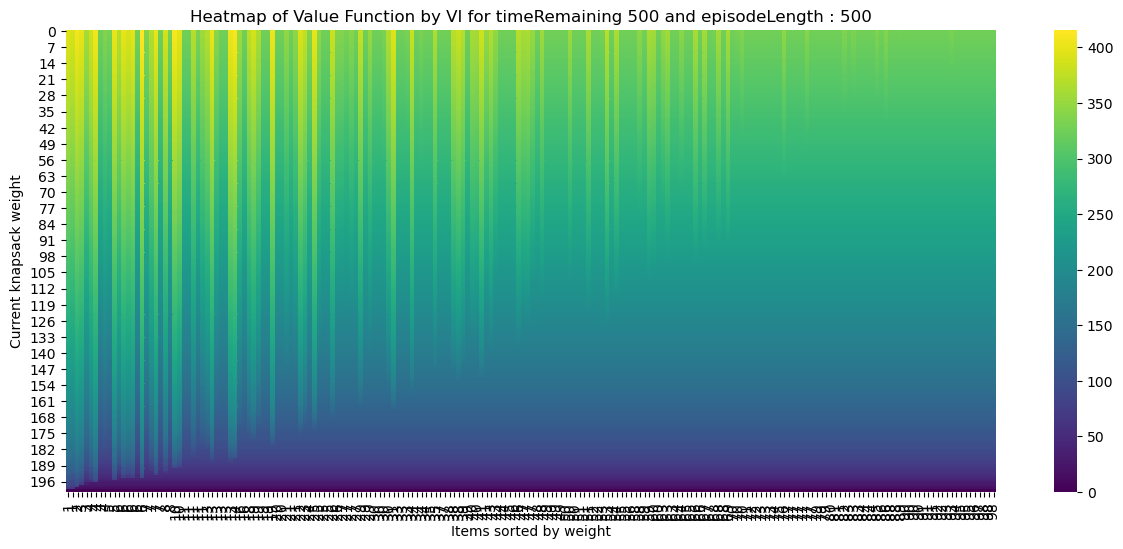

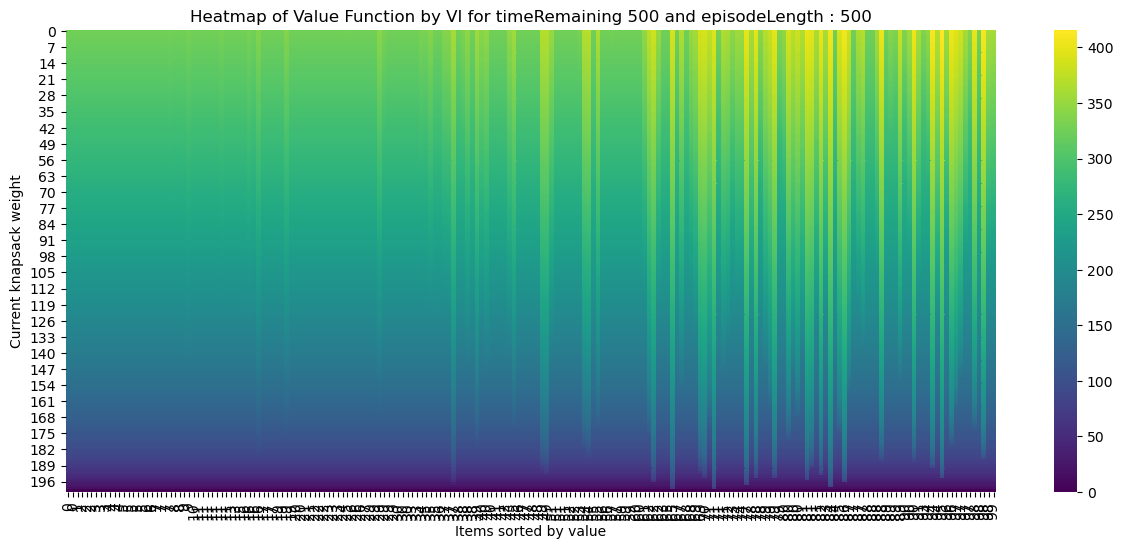

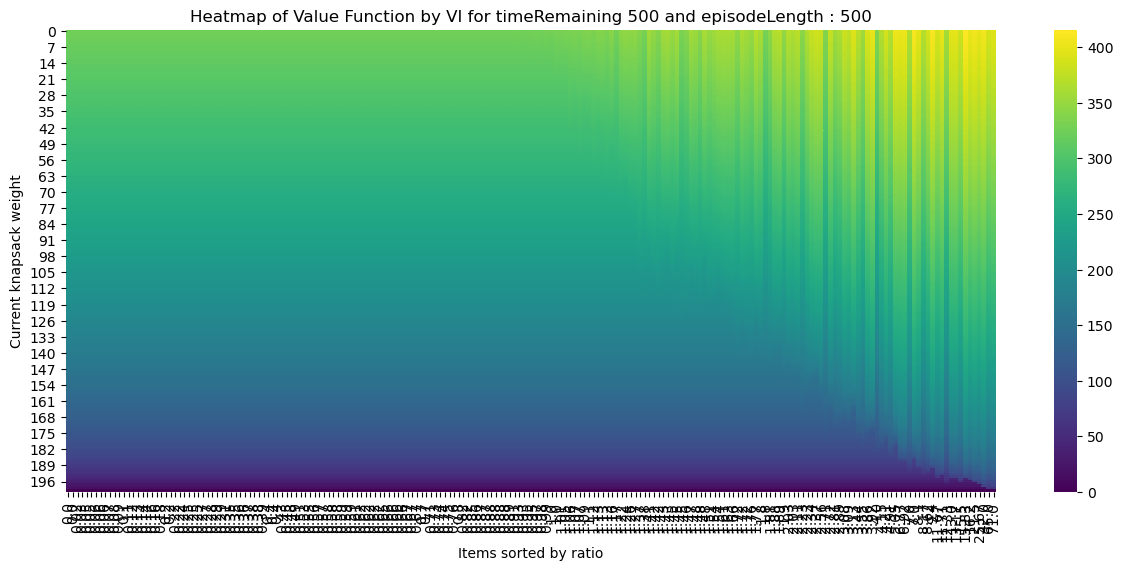

In [21]:
# Q3 :: were given different timeSteps we are asked to built the corresponding heat maps

# one sample for plotting
np.random.seed(0)
env = OnlineKnapsackEnv()

timeSteps = [10, 50, 500]
    
for timeStep in timeSteps:
    value_iteration = ValueIterationOnlineKnapsack(env, episodeLength = timeStep)
    optimalPolicyVI, optimalValueFnVI = value_iteration.run_value_iteration()
    
    print(f"Episode Length : {value_iteration.episodeLength}")
    print(optimalValueFnVI.shape)
    
    plot_value_heatmap(optimalValueFnVI, env, "weight", value_iteration, "VI", timeRemaining = 1, episodeLength = value_iteration.episodeLength)
    plot_value_heatmap(optimalValueFnVI, env, "value", value_iteration, "VI", timeRemaining = 1,  episodeLength = value_iteration.episodeLength)
    plot_value_heatmap(optimalValueFnVI, env, "ratio", value_iteration, "VI", timeRemaining = 1,  episodeLength = value_iteration.episodeLength)
    
    plot_value_heatmap(optimalValueFnVI, env, "weight", value_iteration, "VI", timeRemaining = timeStep,  episodeLength = value_iteration.episodeLength)
    plot_value_heatmap(optimalValueFnVI, env, "value", value_iteration, "VI", timeRemaining = timeStep,  episodeLength = value_iteration.episodeLength)
    plot_value_heatmap(optimalValueFnVI, env, "ratio", value_iteration, "VI", timeRemaining = timeStep,  episodeLength = value_iteration.episodeLength)